In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
from os import listdir
from os.path import isfile, join

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier


%matplotlib inline

In [2]:
full_data = pd.read_csv('../../data/train.csv')
test_data = pd.read_csv('../../data/test.csv')

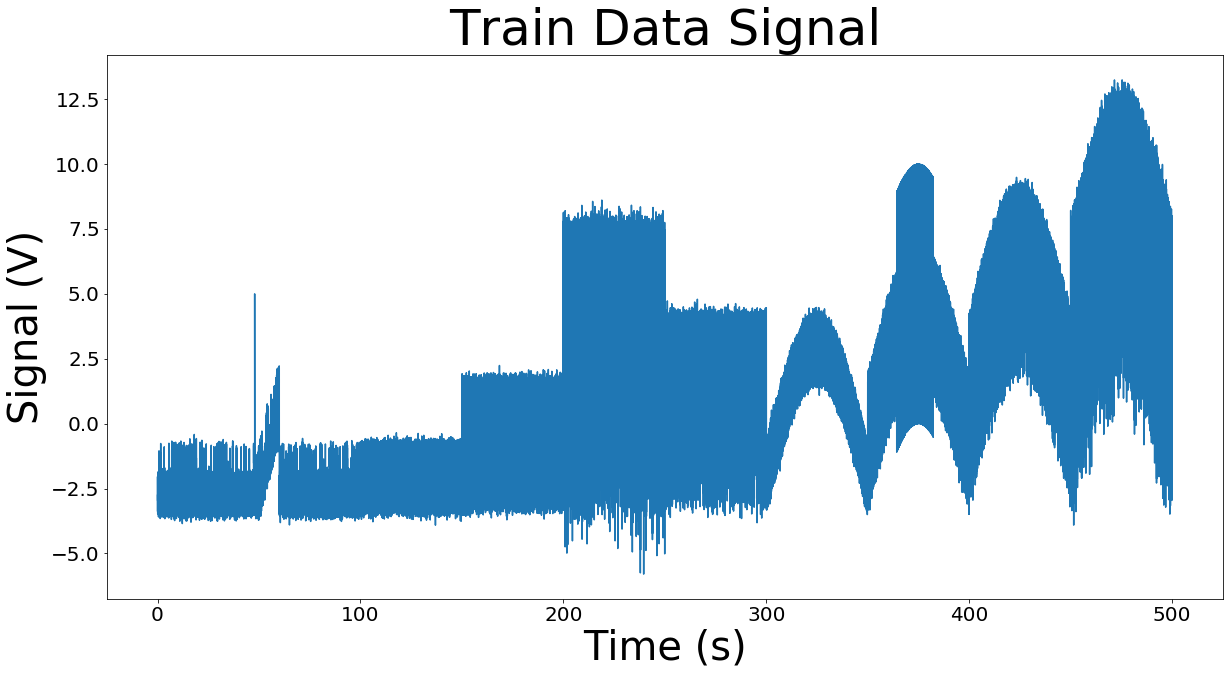

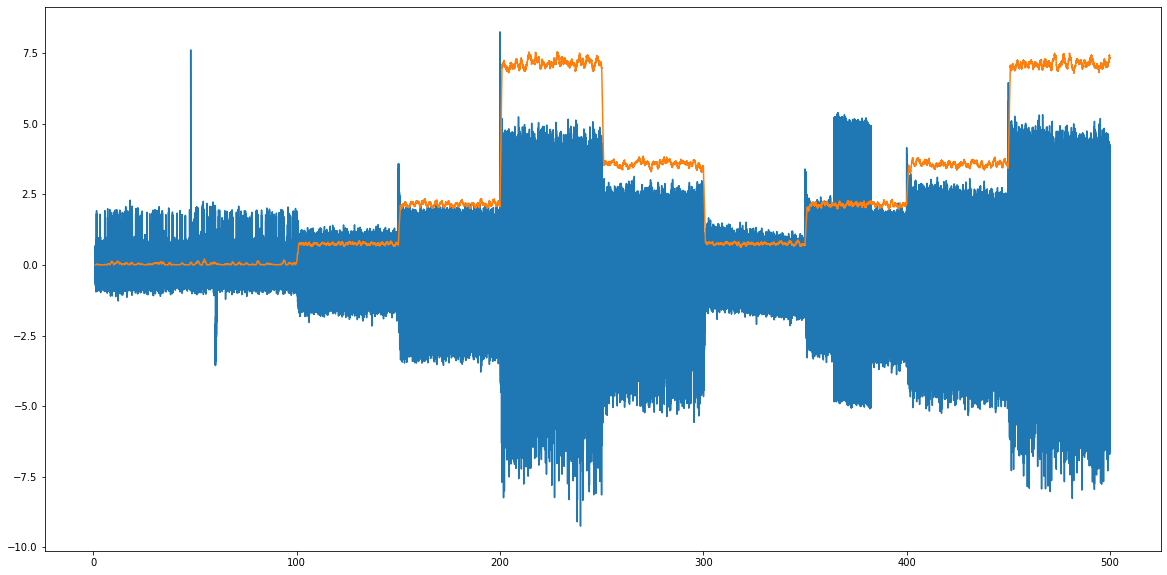

In [3]:
plt.figure(figsize = (20, 10))
plt.plot(full_data['time'], full_data['signal'])
plt.xlabel('Time (s)', fontsize = 40)
plt.xticks(fontsize = 20)
plt.ylabel('Signal (V)', fontsize = 40)
plt.yticks(fontsize = 20)
plt.title("Train Data Signal", fontsize = 50)
#plt.savefig('Train_Data_Signal')
#plt.plot(full_data['time'], full_data['open_channels'] + 20)

rol_mean = full_data['signal'].rolling(10000).mean()
#plt.plot(full_data['time'], rol_mean)

plt.figure(figsize = (20, 10))
plt.plot(full_data['time'], full_data['signal'] - rol_mean)
plt.plot(full_data['time'], full_data['open_channels'].rolling(10000).mean())

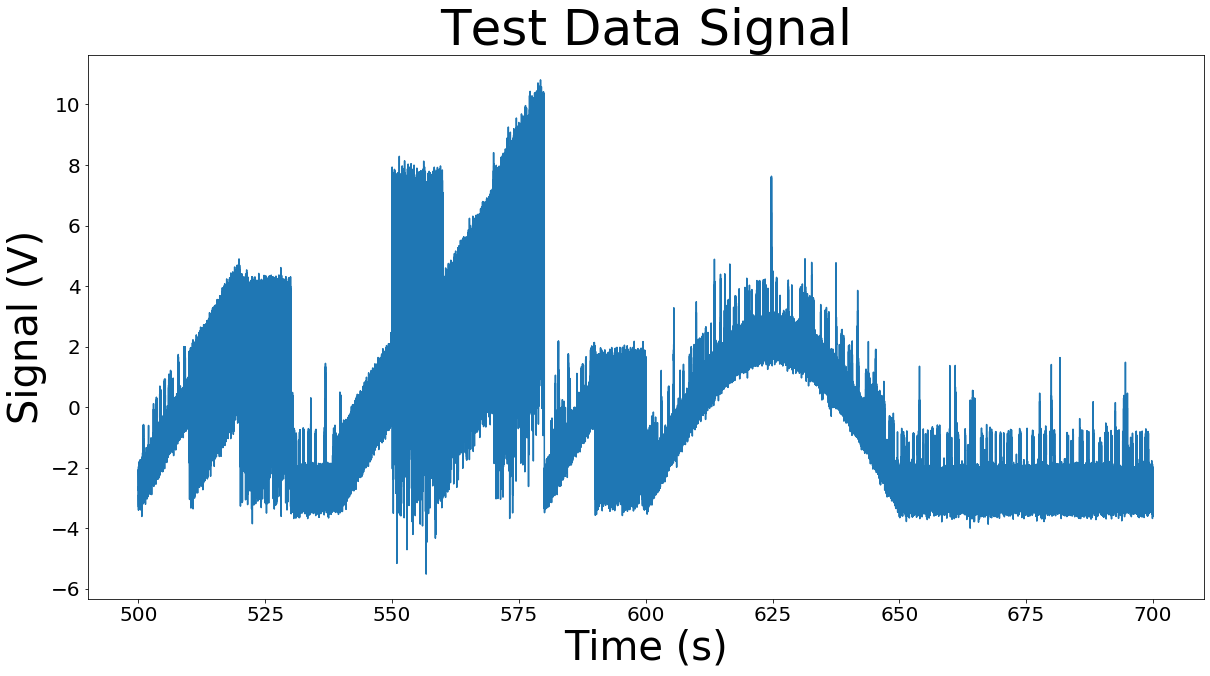

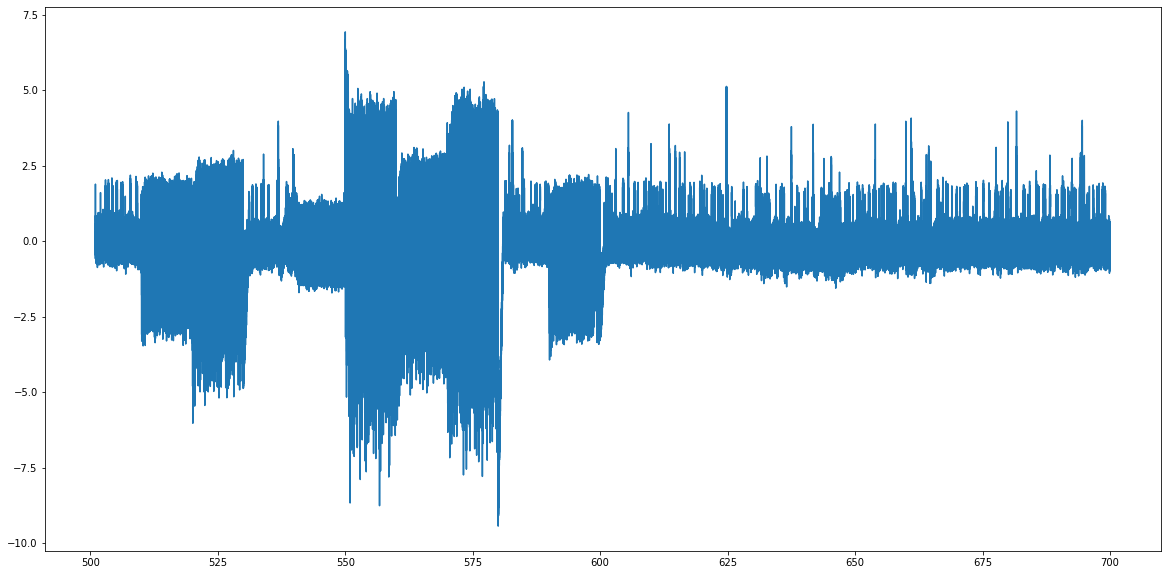

In [4]:
plt.figure(figsize = (20, 10))
plt.plot(test_data['time'], test_data['signal'])
plt.xlabel('Time (s)', fontsize = 40)
plt.xticks(fontsize = 20)
plt.ylabel('Signal (V)', fontsize = 40)
plt.yticks(fontsize = 20)
plt.title("Test Data Signal", fontsize = 50)
plt.savefig('Test_Data_Signal')

rol_mean = test_data['signal'].rolling(10000).mean()
#plt.plot(test_data['time'], rol_mean)

plt.figure(figsize = (20, 10))
plt.plot(test_data['time'], test_data['signal'] - rol_mean)

In [5]:
full_data

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0
...,...,...,...
4999995,499.9996,2.9194,7
4999996,499.9997,2.6980,7
4999997,499.9998,4.5164,8
4999998,499.9999,5.6397,9


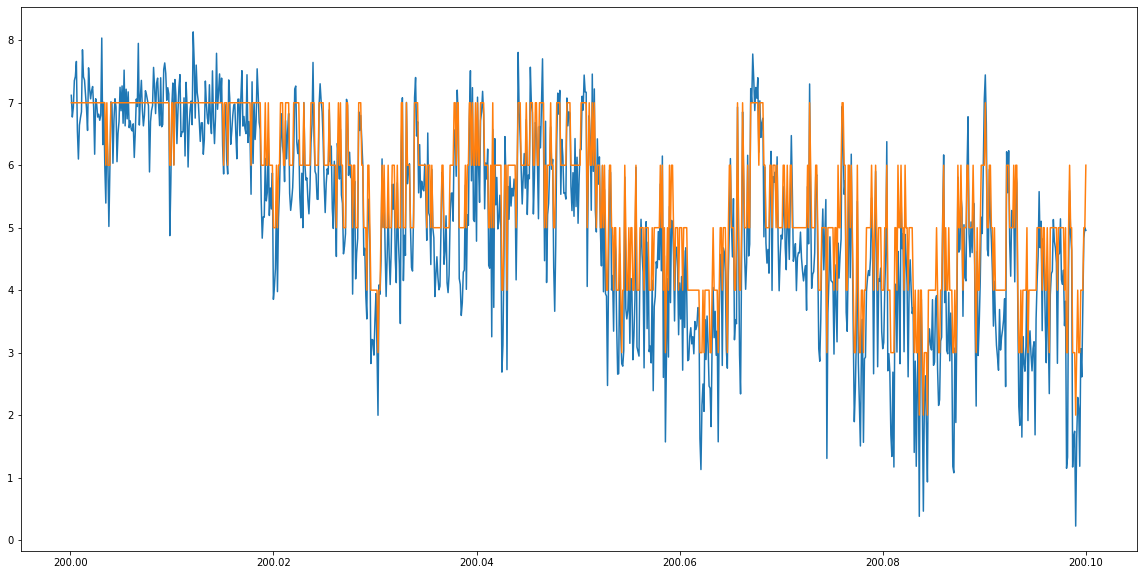

In [6]:
snipet = full_data[2000000:2001000]
plt.figure(figsize = (20, 10))
plt.plot(snipet['time'], snipet['signal'])
plt.plot(snipet['time'], snipet['open_channels'] - 3)

In [7]:
# i, j = 47, 48
# snipet = full_data[int(i*10000):int(j*10000)]
# plt.figure(figsize = (20, 10))
# plt.plot(snipet['time'], snipet['signal'])
# plt.plot(snipet['time'], snipet['open_channels'] + 20)
# plt.vlines(np.linspace(i, j, 50), ymin = -5, ymax = 20)

In [32]:
def convert_to_sliding_window(data):
    sliding_frame = pd.DataFrame(columns = ['signal1',
                                            'signal2',
                                            'signal3',
                                            'signal4',
                                            'signal5',
                                            'signal6',
                                            'signal7',
                                            'signal8',
                                            'signal9',
                                            'signal10',
                                            'open_channels'])
    percent = len(data) // 100
    for index in range(10, len(data)):
        if index % percent == 0: print('>', end = '')
            
        window = data[index - 10: index].copy()
        signals = list(window['signal'])
        open_channel = [list(window['open_channels'])[5]]
        
        new_row = pd.DataFrame([signals + open_channel], columns = sliding_frame.columns)
        sliding_frame = sliding_frame.append(new_row, ignore_index = True)
        
    print(' Done')
    return sliding_frame

def make_sliding_window_file_100k(full_data, start_index):
    snipet = full_data[start_index:start_index + 100000]
    sliding_frame = convert_to_sliding_window(snipet)
    sliding_frame.to_csv(f'sliding_window_100k_{start_index}.csv')

In [ ]:
sliding_frame = convert_to_sliding_window(snipet)

In [ ]:
csvs = [f for f in listdir() if '.csv' in f]
csvs.sort(key = lambda x: int(x[x.index('100k_') + 5:x.index('.csv')]))

full_sliding_window = None
for file in csvs:
    new_frame = pd.read_csv(file)
    if 'Unnamed: 0' in new_frame.columns:
        new_frame.drop(['Unnamed: 0'], axis = 1, inplace = True)
    if file == csvs[0]:
        full_sliding_window = new_frame
    else:
        full_sliding_window = full_sliding_window.append(new_frame)

In [ ]:
full_sliding_window

In [ ]:
#y_preds = rf.predict(X_test)
#y_preds = np.array([int(round(i)) for i in y_preds])

In [8]:
#chunk train data
chunked = list()
lst = np.linspace(0, len(full_data), 11, dtype = int)
for i, j in zip(lst[0:-1], lst[1:]):
    chunked.append(full_data[i:j].copy())
    
strategy = 'mean'    
transformed_by_baseline = [chunk.copy() for chunk in chunked]
for i in transformed_by_baseline:
    exec(f"""new_col = i['signal'].rolling(1000, min_periods = 1).{strategy}()""")
    i['signal'] -= new_col
    
# fix set 1 spike
chunk = transformed_by_baseline[0]
chunk.loc[chunk.index[478585:478615], 'signal'] = chunk.loc[chunk.index[478585:478615], 'signal'] / 16


#chunk = transformed_by_baseline[7]
#chunk.loc[chunk.index[142500:323000], 'signal'] = chunk.loc[chunk.index[142500:323000], 'signal'] / 1.8 - (.62 * int(strategy == 'mean'))

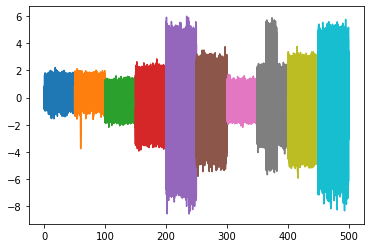

In [9]:
for i in transformed_by_baseline:
    plt.plot(i['time'], i['signal'])

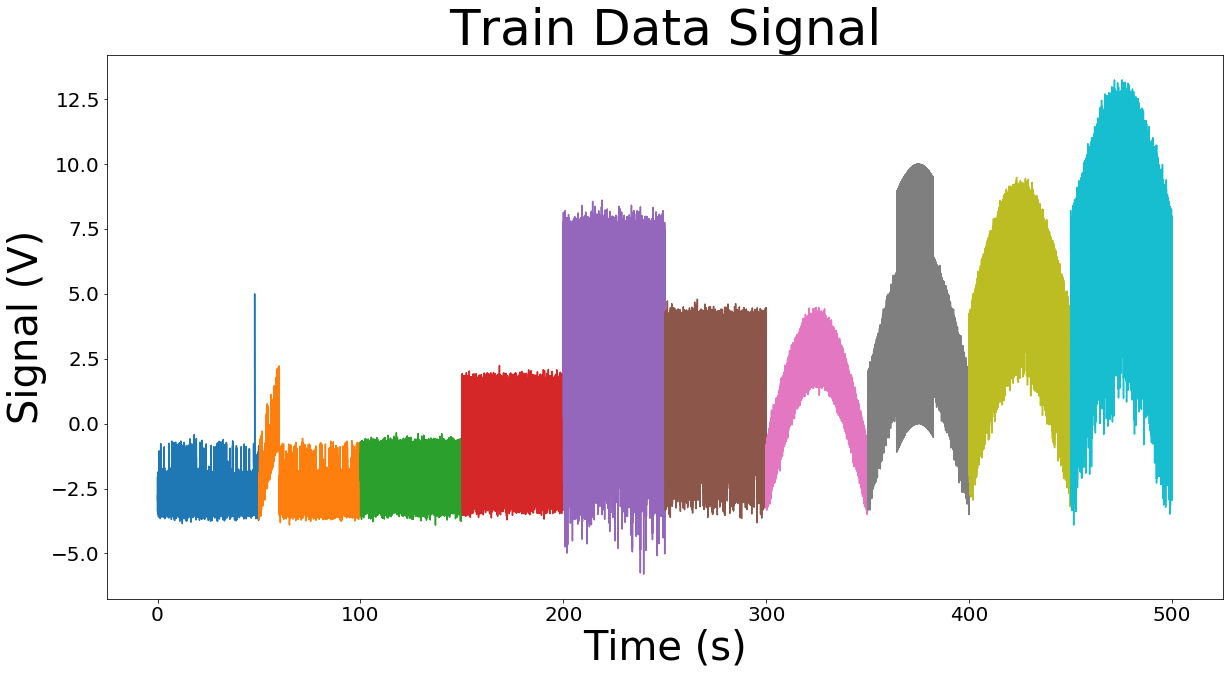

In [10]:
plt.figure(figsize = (20, 10))
for i in chunked:
    plt.plot(i['time'], i['signal']) 

plt.xlabel('Time (s)', fontsize = 40)
plt.xticks(fontsize = 20)
plt.ylabel('Signal (V)', fontsize = 40)
plt.yticks(fontsize = 20)
plt.title("Train Data Signal", fontsize = 50)
plt.savefig('chunked_training')

In [11]:
#chunk data
chunked = list()
for i in range(20):
    chunked.append(test_data[(i) * 100000:(i + 1) * 100000].copy())
    
strategy = 'mean'    
transformed_by_baseline_test = [chunk.copy() for chunk in chunked]
for i in transformed_by_baseline_test:
    exec(f"""new_col = i['signal'].rolling(1000, min_periods = 1).{strategy}()""")
    i['signal'] -= new_col

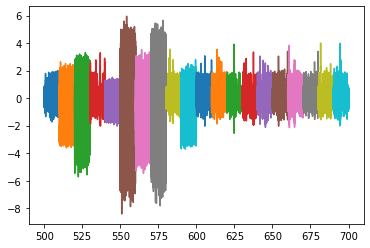

In [12]:
for i in transformed_by_baseline_test:
    plt.plot(i['time'], i['signal'])

In [13]:
# Similar waveforms
# Model 1
# Test: 1, 4, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20
# Train: 1, 2
#
# Model 2
# Test: 5
# Train: 3, 7 
#
# Model 3
# Test: 2, 10
# Train: 4, 8
#
# Model 4
# Test: 3, 7
# Train: 6, 9
#
# Model 5
# Test: 6, 8
# Train: 5, 10

In [14]:
model1_data = pd.concat([transformed_by_baseline[0], transformed_by_baseline[1]])
model2_data = pd.concat([transformed_by_baseline[2], transformed_by_baseline[6]])
model3_data = pd.concat([transformed_by_baseline[3], transformed_by_baseline[7]])
model4_data = pd.concat([transformed_by_baseline[5], transformed_by_baseline[8]])
model5_data = pd.concat([transformed_by_baseline[4], transformed_by_baseline[9]])

In [15]:
'''
current_model = model5_data
y = current_model['open_channels']
X = current_model['signal']
X_train, X_test, y_train, y_test = train_test_split(X, y)
tree = RandomForestRegressor(n_estimators = 10)
tree.fit(pd.DataFrame(X_train), y_train)

y_pred = [int(round(i)) for i in tree.predict(pd.DataFrame(X_test))]
print('test: ', f1_score(y_test, y_pred, average = 'macro'))

y_pred = [int(round(i)) for i in tree.predict(pd.DataFrame(X_train))]
print('train: ', f1_score(y_train, y_pred, average = 'macro'))
#''';

In [29]:
def get_model():
    return RandomForestRegressor(n_estimators = 10)

'''
    estimators = [("rf", RandomForestClassifier(n_estimators = 10)),
                  ("gb", GradientBoostingClassifier())]
    
    
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor''';

In [31]:
model1 = get_model().fit(pd.DataFrame(model1_data['signal']), model1_data['open_channels'])
model2 = get_model().fit(pd.DataFrame(model2_data['signal']), model2_data['open_channels'])
model3 = get_model().fit(pd.DataFrame(model3_data['signal']), model3_data['open_channels'])
model4 = get_model().fit(pd.DataFrame(model4_data['signal']), model4_data['open_channels'])
model5 = get_model().fit(pd.DataFrame(model5_data['signal']), model5_data['open_channels']) #RandomForestClassifier(n_estimators = 20).fit(pd.DataFrame(model5_data['signal']), model5_data['open_channels'])

In [32]:
def predict(model, test_data):
    y_predictions = [int(round(prediction)) for prediction in model.predict(pd.DataFrame(test_data['signal']))]
    return pd.DataFrame({'time' : test_data['time'].values, 'open_channels' : y_predictions})

In [33]:
predictions = pd.DataFrame(columns = ['time', 'open_channels'])
predictions = pd.concat([predictions, predict(model1, transformed_by_baseline_test[0])])
predictions = pd.concat([predictions, predict(model3, transformed_by_baseline_test[1])])
predictions = pd.concat([predictions, predict(model4, transformed_by_baseline_test[2])])
predictions = pd.concat([predictions, predict(model1, transformed_by_baseline_test[3])])
predictions = pd.concat([predictions, predict(model2, transformed_by_baseline_test[4])])
predictions = pd.concat([predictions, predict(model5, transformed_by_baseline_test[5])])
predictions = pd.concat([predictions, predict(model4, transformed_by_baseline_test[6])])
predictions = pd.concat([predictions, predict(model5, transformed_by_baseline_test[7])])
predictions = pd.concat([predictions, predict(model1, transformed_by_baseline_test[8])])
predictions = pd.concat([predictions, predict(model3, transformed_by_baseline_test[9])])
predictions = pd.concat([predictions, predict(model1, transformed_by_baseline_test[10])])
predictions = pd.concat([predictions, predict(model1, transformed_by_baseline_test[11])])
predictions = pd.concat([predictions, predict(model1, transformed_by_baseline_test[12])])
predictions = pd.concat([predictions, predict(model1, transformed_by_baseline_test[13])])
predictions = pd.concat([predictions, predict(model1, transformed_by_baseline_test[14])])
predictions = pd.concat([predictions, predict(model1, transformed_by_baseline_test[15])])
predictions = pd.concat([predictions, predict(model1, transformed_by_baseline_test[16])])
predictions = pd.concat([predictions, predict(model1, transformed_by_baseline_test[17])])
predictions = pd.concat([predictions, predict(model1, transformed_by_baseline_test[18])])
predictions = pd.concat([predictions, predict(model1, transformed_by_baseline_test[19])])

In [34]:
predictions.to_csv('~/Desktop/test_predictions.csv', index = False, float_format='%.4f')

In [35]:
predictions

,time,open_channels
0,500.0001,0
1,500.0002,0
2,500.0003,0
3,500.0004,0
4,500.0005,0
...,...,...
99995,699.9996,0
99996,699.9997,0
99997,699.9998,0
99998,699.9999,0


In [ ]:
sys.getsizeof(model1_data) // 1000000

In [ ]:
sys.getsizeof(full_sliding_window) // 1000000

In [3]:
sys.getsizeof(full_data) // 1000000

120

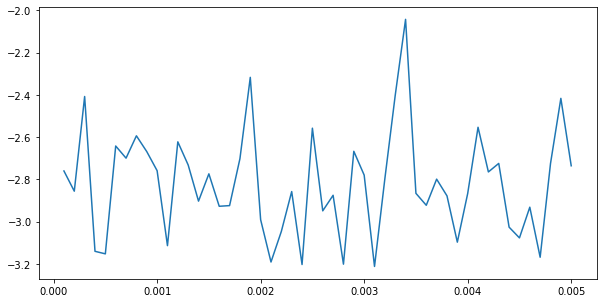

In [12]:
plt.figure(figsize = (10, 5))
plt.plot(full_data['time'][:50], full_data['signal'][:50])

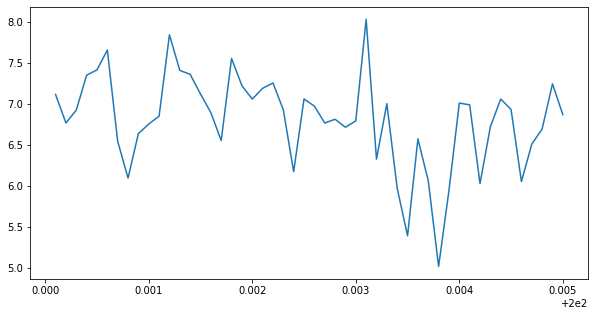

In [11]:
plt.figure(figsize = (10, 5))
plt.plot(full_data['time'][2000000:2000050], full_data['signal'][2000000:2000050])

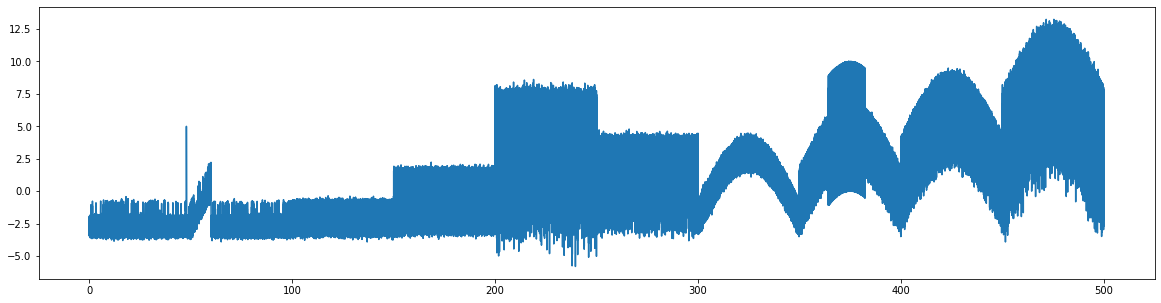

In [8]:
plt.figure(figsize = (20, 5))
plt.plot(full_data['time'], full_data['signal'])

In [ ]:
def f(a, b):
    print(a, b)

d = {'a' : 1, 'b' : 2}
f(**d)

def f(**kwargs):
    print(kwargs)

f(a = 1, b = 2)

def f(*args):
    print(args)

f(1, 2, 3)